# Hi, Jeremy/Howard:

I considered working on a game like Doom at first, but I kept running into issues with training and my computer crashing. Instead I present a problem my computer can handle: Gridworld, initially presented by Sutton and Barto, who I referenced in my final paper. I wanted to tackle this problem because I've taken 'Intro to AI' at Northwestern before, and we discussed planning; this has some similar, real-world application to it. This work originally stems from David Sanwald's teaching, but I experimented with this further and revisited some concepts enough to understand how everything worked.

For Gridworld, there are 4 rules:

1. You, the agent, start in the top left, at coordinate (0, 0)
2. You can move 1 space per turn
3. An iteration ends by:
   - You reaching the goal state
   - You walking on a death trap
4. Per time step, the 'discount factor' in in this case is a negative point valued at -1

Let's start!

In [171]:
import warnings
warnings.filterwarnings('ignore')

In [172]:
import time

import random as rd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from collections import defaultdict, namedtuple
from itertools import product, starmap
from scipy import stats
%matplotlib inline
rd.seed(1234)

In [173]:
sns.set_context("poster")

coord = namedtuple('coord', ['m', 'n'])

coords     = [coord(0,0), coord(0,1), coord(0,2), coord(0,3), coord(0,4), coord(0,5), coord(0,6), coord(0,7), coord(0,8), coord(0,9), coord(0,10), coord(0,11),
              coord(1,0), coord(1,1), coord(1,2), coord(1,3), coord(1,4), coord(1,5), coord(1,6), coord(1,7), coord(1,8), coord(1,9), coord(1,10), coord(1,11),
              coord(2,0), coord(2,1), coord(2,2), coord(2,3), coord(2,4), coord(2,5), coord(2,6), coord(2,7), coord(2,8), coord(2,9), coord(2,10), coord(2,11),
              coord(3,0), coord(3,1), coord(3,2), coord(3,3), coord(3,4), coord(3,5), coord(3,6), coord(3,7), coord(3,8), coord(3,9), coord(3,10), coord(3,11),
              coord(4,0), coord(4,1), coord(4,2), coord(4,3), coord(4,4), coord(4,5), coord(4,6), coord(4,7), coord(4,8), coord(4,9), coord(4,10), coord(4,11),
              coord(5,0), coord(5,1), coord(5,2), coord(5,3), coord(5,4), coord(5,5), coord(5,6), coord(5,7), coord(5,8), coord(5,9), coord(5,10), coord(5,11),
              coord(6,0), coord(6,1), coord(6,2), coord(6,3), coord(6,4), coord(6,5), coord(6,6), coord(6,7), coord(6,8), coord(6,9), coord(6,10), coord(6,11),
              coord(7,0), coord(7,1), coord(7,2), coord(7,3), coord(7,4), coord(7,5), coord(7,6), coord(7,7), coord(7,8), coord(7,9), coord(7,10), coord(7,11)]

# death traps on top row
death_traps = (coords[1:11])

# death traps as a column
death_traps.append(coord(m=1,n=3))
death_traps.append(coord(m=2,n=3))
death_traps.append(coord(m=3,n=3))
death_traps.append(coord(m=4,n=3))
death_traps.append(coord(m=5,n=3))
death_traps.append(coord(m=6,n=3))

death_traps.append(coord(m=4,n=4))
death_traps.append(coord(m=4,n=5))
death_traps.append(coord(m=4,n=6))
death_traps.append(coord(m=4,n=7))
death_traps.append(coord(m=4,n=8))
death_traps.append(coord(m=4,n=9))

# goal/start coordinates
GOAL = coord(m=1, n=4)
START = coord(m=0, n=0)

# conditions when landing
discount_fn = -1
blow_up = -100
END = death_traps + [GOAL]

# agent behavior
step = {'>': coord(0, 1),
        '<': coord(0, -1),
        'v': coord(1, 0),
        '^': coord(-1, 0)}

initial_world_params = {'coords': coords,
                        'death_traps': death_traps,
                        'START': START,
                        'GOAL': GOAL,
                        'END': END,
                        'discount_fn': discount_fn,
                        'blow_up': blow_up,
                        'step': step}

all_colors = matplotlib.colors.ListedColormap(['#EFEFEF', # empty space
                                               '#B22222', # lose space
                                               '#FFCC66', # GOAL space
                                               '#56B9EB']) # START space

In [174]:
cost = np.full((8,12), -1, dtype='int64')
coord_color = np.zeros((8,12))

def color_coords():
    for x in coords:
        if x == START:
            coord_color[x] = 4
            cost[x] = -1
        if x == GOAL:
            coord_color[x] = 2
            cost[x] = -1
        if x in death_traps:
            coord_color[x] = 1
            cost[x] = -100
    print(coord_color)
    
    plt.figure(figsize=(11,8))
    ax = sns.heatmap(coord_color,
                     cmap=all_colors,
                     annot=cost,
                     cbar=False,
                     square=True,
                     linewidths=1,
                     fmt='')
    ax.set_title('world0 represented by coordinate information:\n')
    plt.show()

## This is a representation of the map I drew myself. I could have made it anything I wanted

- The blue represents the START,

- The yellow represents the GOAL,

- The red represents the death traps,

- and the white contains nothing upon it

[[4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


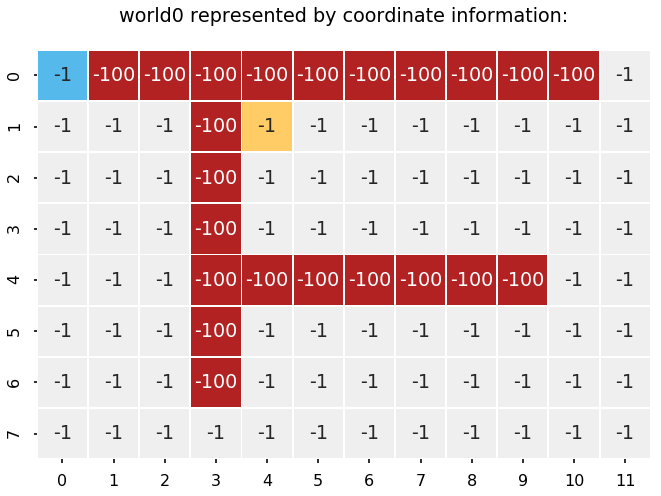

In [175]:
color_coords()

In [176]:
class GRIDWORLD:
    def __init__(self, *init, **kwargs):
        for d in init:
            for k in d:
                setattr(self, k, d[k])
        for k in kwargs:
            setattr(self, k, kwargs[k])
        self.history = []
        self.position = [self.START]
        self.log = {}
        self.total_pts = 0
    
    def NEXT(self, state, action):
        move = step[action]
        NEXT = coord(state.m + move.m,
                     state.n + move.n)
        self.position.append(NEXT)
        return NEXT
    
    def points(self, state):
        if state in self.death_traps:
            points = self.blow_up
        else:
            points = self.discount_fn
        self.total_pts += points
        return points
    
    def log_state(self, state):
        self.position.append(state)
        self.log['visited'] = self.position[:]
        self.log['points'] = self.total_pts
        self.history.append(self.log)
        self.log = {}
        self.position = [self.START]
        self.log = {}
        self.total_pts = 0
        pass
    
    def can_do(self, state):
        possible_moves = []
        if (state.m + step['>'].m, state.n + step['>'].n) in self.coords:
            possible_moves.append('>')
        if (state.m + step['v'].m, state.n + step['v'].n) in self.coords:
            possible_moves.append('v')
        if (state.m + step['<'].m, state.n + step['<'].n) in self.coords:
            possible_moves.append('<')
        if (state.m + step['^'].m, state.n + step['^'].n) in self.coords:
            possible_moves.append('^')
        return possible_moves
    
    def GAMEOVER(self, state):
        if state in self.END:
            self.log_state(state)
            return True
        else:
            return False

world0 = GRIDWORLD(initial_world_params)

In [177]:
# he gets lost too easy. Basically random.
# https://www.youtube.com/watch?v=MtgmAO9-PNE
class Roronoa_Zoro:
    def __init__(self):
        self.total_pts = 0
        pass
    
    def act(self, state, possible_moves):
        action = rd.choice(possible_moves)
        return action
    
    def learn(self, state, action, NEXT, points):
        self.total_pts += points
        pass

def go(world0, agent):
    state = world0.START
    while not world0.GAMEOVER(state):
        possible_moves = world0.can_do(state)
        action = agent.act(state, possible_moves)
        NEXT = world0.NEXT(state, action)
        points = world0.points(NEXT)
        agent.learn(state, action, NEXT, points)
        state = NEXT
    pass

go(world0, Roronoa_Zoro())

In [179]:
def plot_path():
    where_visited = world0.history[-1]['visited']
    agent_path = np.empty((8, 12), dtype=str)
    for state_visited in where_visited:
        if state_visited in END:
            agent_path[state_visited] = 'X'
        else:
            agent_path[state_visited] = 'O'
    ax = plt.axes()
    ax.set_title('Path of agent across GRIDWORLD:\n')
    figure = sns.heatmap(coord_color,
                         annot = agent_path,
                         fmt = '',
                         ax=ax,
                         cbar=False,
                         linewidth = 1,
                         cmap = all_colors,
                         square=True)
    figure.set(xlabel='n', ylabel='m')
    sns.despine()

## This is the path that an agent with RANDOM movement took
Pretty close honestly..

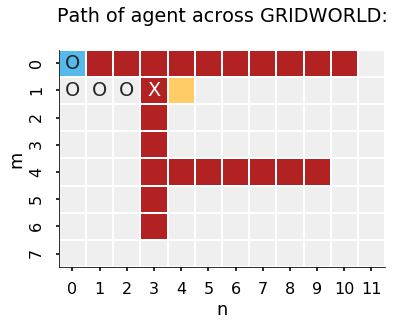

In [180]:
plot_path()

In [181]:
class Q:
    def __init__(self, alpha, epsilon, gamma):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(int)
        self.A = defaultdict(set)
        self.td_list = []
    
    def act(self, state, possible_moves):
        if rd.random() > self.epsilon:
            action = self.act_greedy(state, possible_moves)
        else:
            action = self.act_random(possible_moves)
        return action
    
    def learn(self, state, action, NEXT, points):
        self.Q[state, action] = (self.Q[state, action] + self.alpha * (self.td(state, action, NEXT, points)))
        self.A[state].add(action)
        pass
    
    def act_random(self, possible_moves):
        random_action = rd.choice(possible_moves)
        return random_action
    
    def act_greedy(self, state, possible_moves):
        if len(self.A[state]) == 0:
            chosen_action = self.act_random(possible_moves)
        else:
            q_s = {actions: self.Q[state, actions]
                   for actions in self.A[state]}
            chosen_action = max(q_s, key=q_s.get)
        return chosen_action
    
    def td(self, state, action, NEXT, points):
        if len(self.A[NEXT]) == 0:
            max_qval = 0
        else:
            q_vals = {actions: self.Q[NEXT, actions]
                      for actions in self.A[NEXT]}
            max_qval_key = max(q_vals, key=q_vals.get)
            max_qval = q_vals[max_qval_key]
        td = points + self.gamma * max_qval - self.Q[state, action]
        self.td_list.append(td)
        return td

In [182]:
def play(world0, agent, epsilon_decay, n_episodes):
    for i in range(n_episodes):
        agent.epsilon *= epsilon_decay
        go(world0, agent)
    agent.epsilon = 0
    go(world0, agent)
    last_points = world0.history[-1]['points']
    print('Trained over: ' + str(n_episodes) + ' iterations, and best score was: ' + str(last_points))

#### I believe the best possible score is -29, but the seed I set it to finds -31 at 500 iterations

In [183]:
epsilon, epsilon_decay, gamma, alpha, n_episodes = 0.9, .99, .9, .25, 300
world0 = GRIDWORLD(initial_world_params)
qworld = Q(alpha, epsilon, gamma)
play(world0, qworld, epsilon_decay, n_episodes)
logged_data300, Q_table300, A_table300, td300 = world0.history, qworld.Q, qworld.A, qworld.td_list

epsilon, epsilon_decay, gamma, alpha, n_episodes = 0.9, .99, .9, .25, 500
world0 = GRIDWORLD(initial_world_params)
qworld = Q(alpha, epsilon, gamma)
play(world0, qworld, epsilon_decay, n_episodes)
logged_data500, Q_table500, A_table500, td500 = world0.history, qworld.Q, qworld.A, qworld.td_list

Trained over: 300 iterations, and best score was: -57
Trained over: 500 iterations, and best score was: -31


In [184]:
# run this cell to reset in case of emergency if kernel above freezes
# logged_data = world0.history
# Q_table = qworld.Q
# A_table = qworld.A
# td = qworld.td_list

In [185]:
def plot(logged_data, Q_table, A_table, td):
    print('')
    action_array = np.empty((8,12), dtype=str)
    value_array = np.empty((8,12), dtype=float)
    for state in world0.coords:
        if len(A_table[state])==0:
            chosen_action = 'X'
        else:
            q_s = {actions: Q_table[state, actions] 
                   for actions in A_table[state]}
            chosen_action = max(q_s, key=q_s.get)
            max_qval = q_s[chosen_action]
        action_array[state] = chosen_action
        value_array[state] = max_qval
        action_array[GOAL] = 'G'
    
    ax = plt.axes()
    plt.figure(figsize=(5,5))
    plt.figure(1)
    figure = sns.heatmap(value_array, annot = action_array,  fmt= '', square=True, cbar=False, cmap='copper')
    ax.set_title("Heatmap of Agent's strategy (or 'policy') across Gridworld:\n")
    figure.set(ylabel='m', xlabel='n')
    sns.despine()
    
    plt.figure(figsize=(5,5))
    plt.figure(2)
    plot_path()
    
    plt.figure(figsize=(5,5))
    plt.figure(3)
    points = [i['points'] for i in logged_data]
    figure = sns.tsplot(points, color= 'purple')
    figure.set(ylabel='Score per iteration', xlabel='# of iteration/episode')
    sns.despine()
    
    plt.figure(figsize=(5,5))
    plt.figure(4)
    figure = sns.tsplot(td, color= 'purple')
    figure.set(ylabel="TD Error per step", xlabel='# of steps')
    sns.despine()

## This is the path that an agent using Q-LEARNING took
The following are illustrations of GridWorld traveled after 500 iterations/episodes

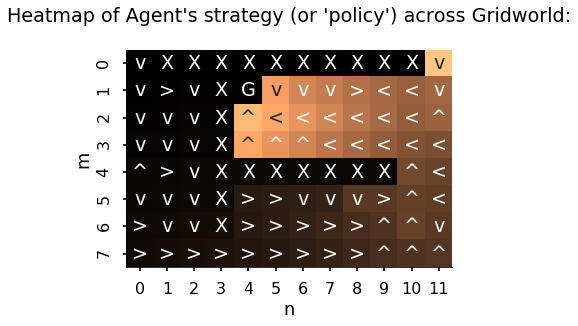

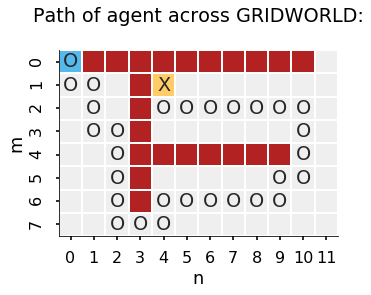

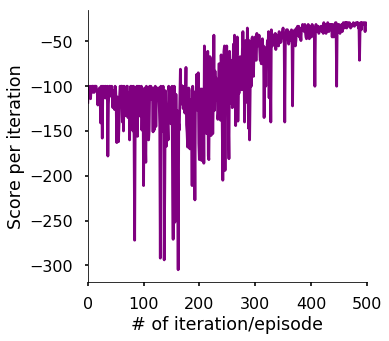

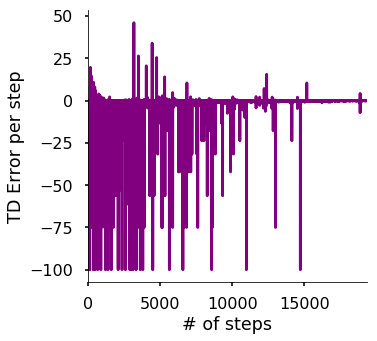

<Figure size 360x360 with 0 Axes>

In [186]:
plot(logged_data500, Q_table500, A_table500, td500)